# Extended Figure 17

# Prepare data

In [102]:
import os
import pandas as pd
import numpy as np
import scanpy as sc

from cnmf import cNMF
from statsmodels.stats.multitest import multipletests
from pygam import GAM, s
import scipy.stats as stats

import mplscience
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

seed = 777

output_path = '../output/forNMF/scVI_filter'
data_path = '../output/'
plot_path = '../plot/'
marker_path = '../markers/'

In [20]:
adata = sc.read_h5ad(os.path.join(output_path, 'subcluster.h5ad'))
cnmf_obj = cNMF(output_dir = '../output/forNMF/scVI_filter', name = 'subcluster')
usage_norm, gep_scores, gep_tpm, topgenes = cnmf_obj.load_results(K=8, density_threshold=0.5)
usage_norm.columns = [f'NMF_Module_{i}' for i in usage_norm.columns]

In [21]:
adata.obs = pd.merge(left = adata.obs, right = usage_norm, left_index = True, right_index = True, how = 'left')

In [22]:
adata.obs['max_module'] = usage_norm.idxmax(1)

In [30]:
pt = pd.read_csv(os.path.join(marker_path, 'pseudotime.csv'), index_col = 0, names=['pseudotime'], skiprows=1)
adata.obs = pd.merge(left = adata.obs, right = pt, left_index = True, right_index = True, how = 'left')
adata

AnnData object with n_obs × n_vars = 16088 × 10350
    obs: 'sample_id', 'barcode', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'scDblFinder_score', 'scDblFinder_class', 'grade', 'GFP', '_scvi_batch', '_scvi_labels', 'leiden_res2', 'old_cell_type', 'wb_anno', 'wb_conf_score', 'gb_anno', 'gb_conf_score', 'cellid_prediction', 'cell_type', 'leiden', 'NMF_Module_1', 'NMF_Module_2', 'NMF_Module_3', 'NMF_Module_4', 'NMF_Module_5', 'NMF_Module_6', 'NMF_Module_7', 'NMF_Module_8', 'max_module', 'pseudotime'
    var: 'n_cells'
    uns: 'GFP_colors', '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'hvg', 'leiden', 'leiden_res2_colors', 'neighbors', 'umap'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_continuous_covs'
    layers: 'counts', 'scvi_normalized'
    obsp: 'connectivities', 'distances'

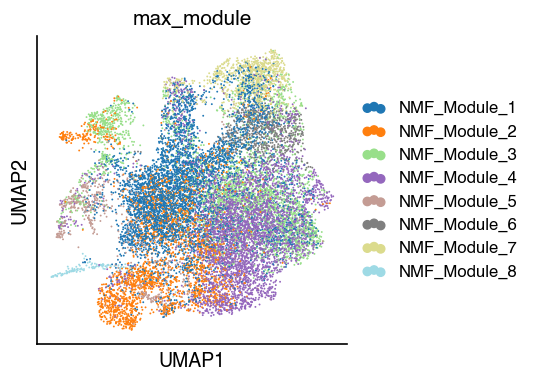

In [17]:
with mplscience.style_context():
    sc.pl.umap(adata, color = ['max_module'], palette = 'tab20')

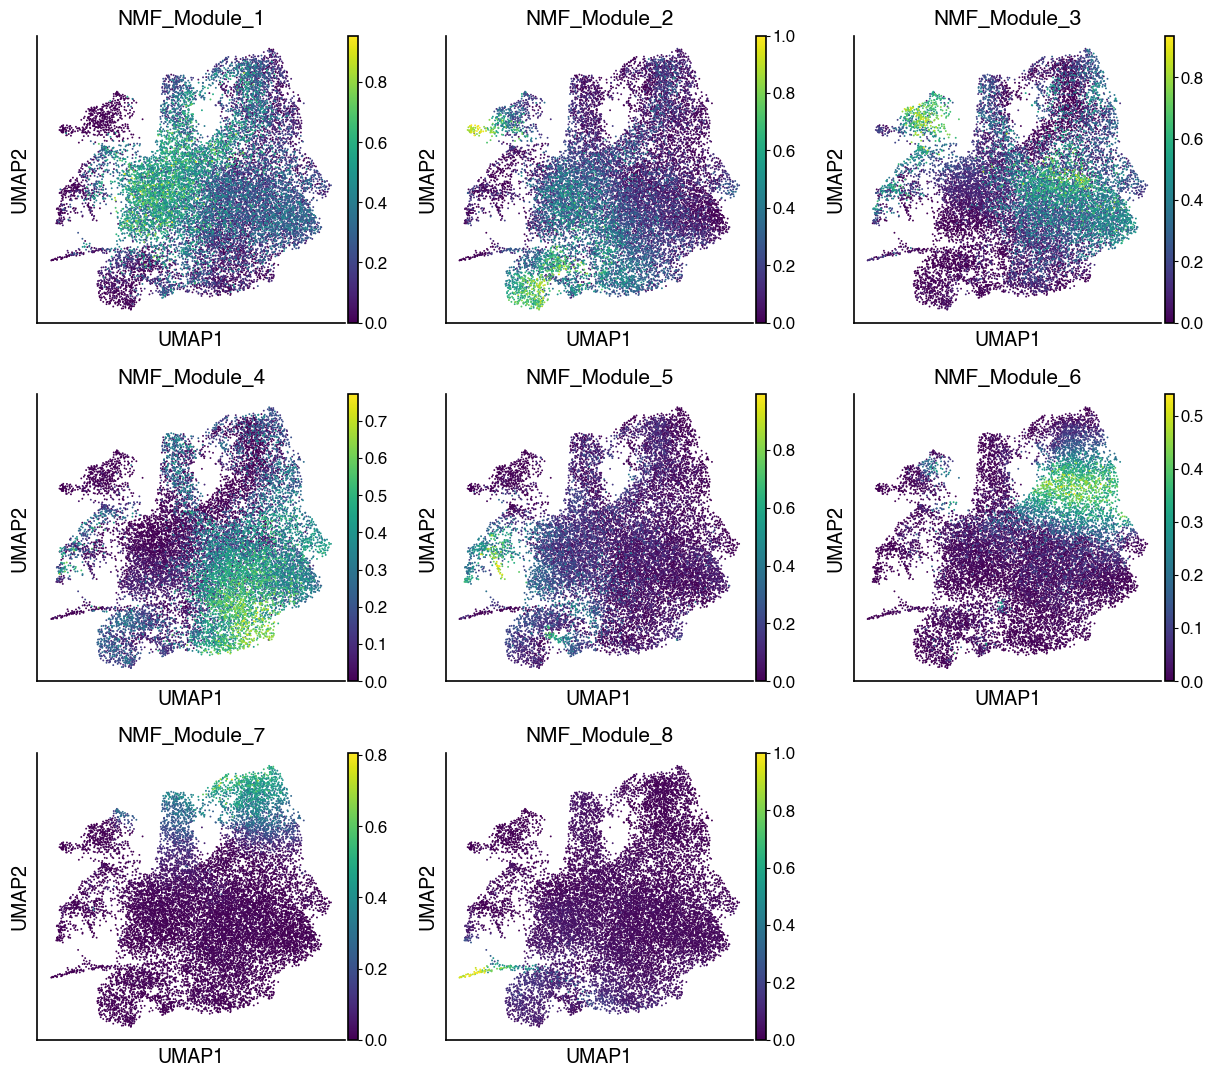

In [16]:
names = [c for c in adata.obs_keys() if c.startswith('NMF_Module')]
with mplscience.style_context():
    sc.pl.umap(adata, color = names, ncols = 3, cmap = 'viridis', use_raw = False)

# Fit model : Pseudotime vs Modules

In [119]:
def fit_gam(x, y):
    sort_idx = np.argsort(x)
    x_sorted = x[sort_idx]
    y_sorted = y[sort_idx]
    
    gam = GAM(s(0, n_splines=10, basis='ps', spline_order=3))
    gam.fit(x_sorted.reshape(-1, 1), y_sorted)
    return gam


results = {}
p_values = []
modules = [c for c in adata.obs_keys() if c.startswith('NMF_Module')]

for module in modules:
    x = adata.obs.pseudotime.values
    y = adata.obs[module].values
    
    gam = fit_gam(x, y)
    correlation, p_value = stats.spearmanr(x, y)
    
    results[module] = {'gam': gam, 'correlation' : correlation, 'p_value': p_value}
    p_values.append(p_value)

adjusted_p_values = multipletests(p_values, method='fdr_bhfdr_bh')[1]
significant_modules = [module for module, p_value in zip(modules, adjusted_p_values) if p_value < 0.05]

top_modules = sorted(zip(modules, adjusted_p_values), key=lambda x: x[1])[:5]

print(f"Total modules tested: {len(modules)}")
significant_modules = [module for module, p_value in zip(modules, adjusted_p_values) if p_value < 0.05]
print(f"Significant modules: {len(significant_modules)}")
print("\nModule statistics:")
for module, p_value in zip(modules, adjusted_p_values):
    print(f"{module}: r = {results[module]['correlation']:.2f}, adjusted p-value = {p_value:.4e}")

Total modules tested: 8
Significant modules: 8

Module statistics:
NMF_Module_1: r = 0.05, adjusted p-value = 9.4279e-11
NMF_Module_2: r = -0.50, adjusted p-value = 0.0000e+00
NMF_Module_3: r = 0.21, adjusted p-value = 1.3113e-154
NMF_Module_4: r = -0.17, adjusted p-value = 3.2431e-103
NMF_Module_5: r = -0.18, adjusted p-value = 5.8471e-112
NMF_Module_6: r = 0.38, adjusted p-value = 0.0000e+00
NMF_Module_7: r = 0.42, adjusted p-value = 0.0000e+00
NMF_Module_8: r = -0.52, adjusted p-value = 0.0000e+00


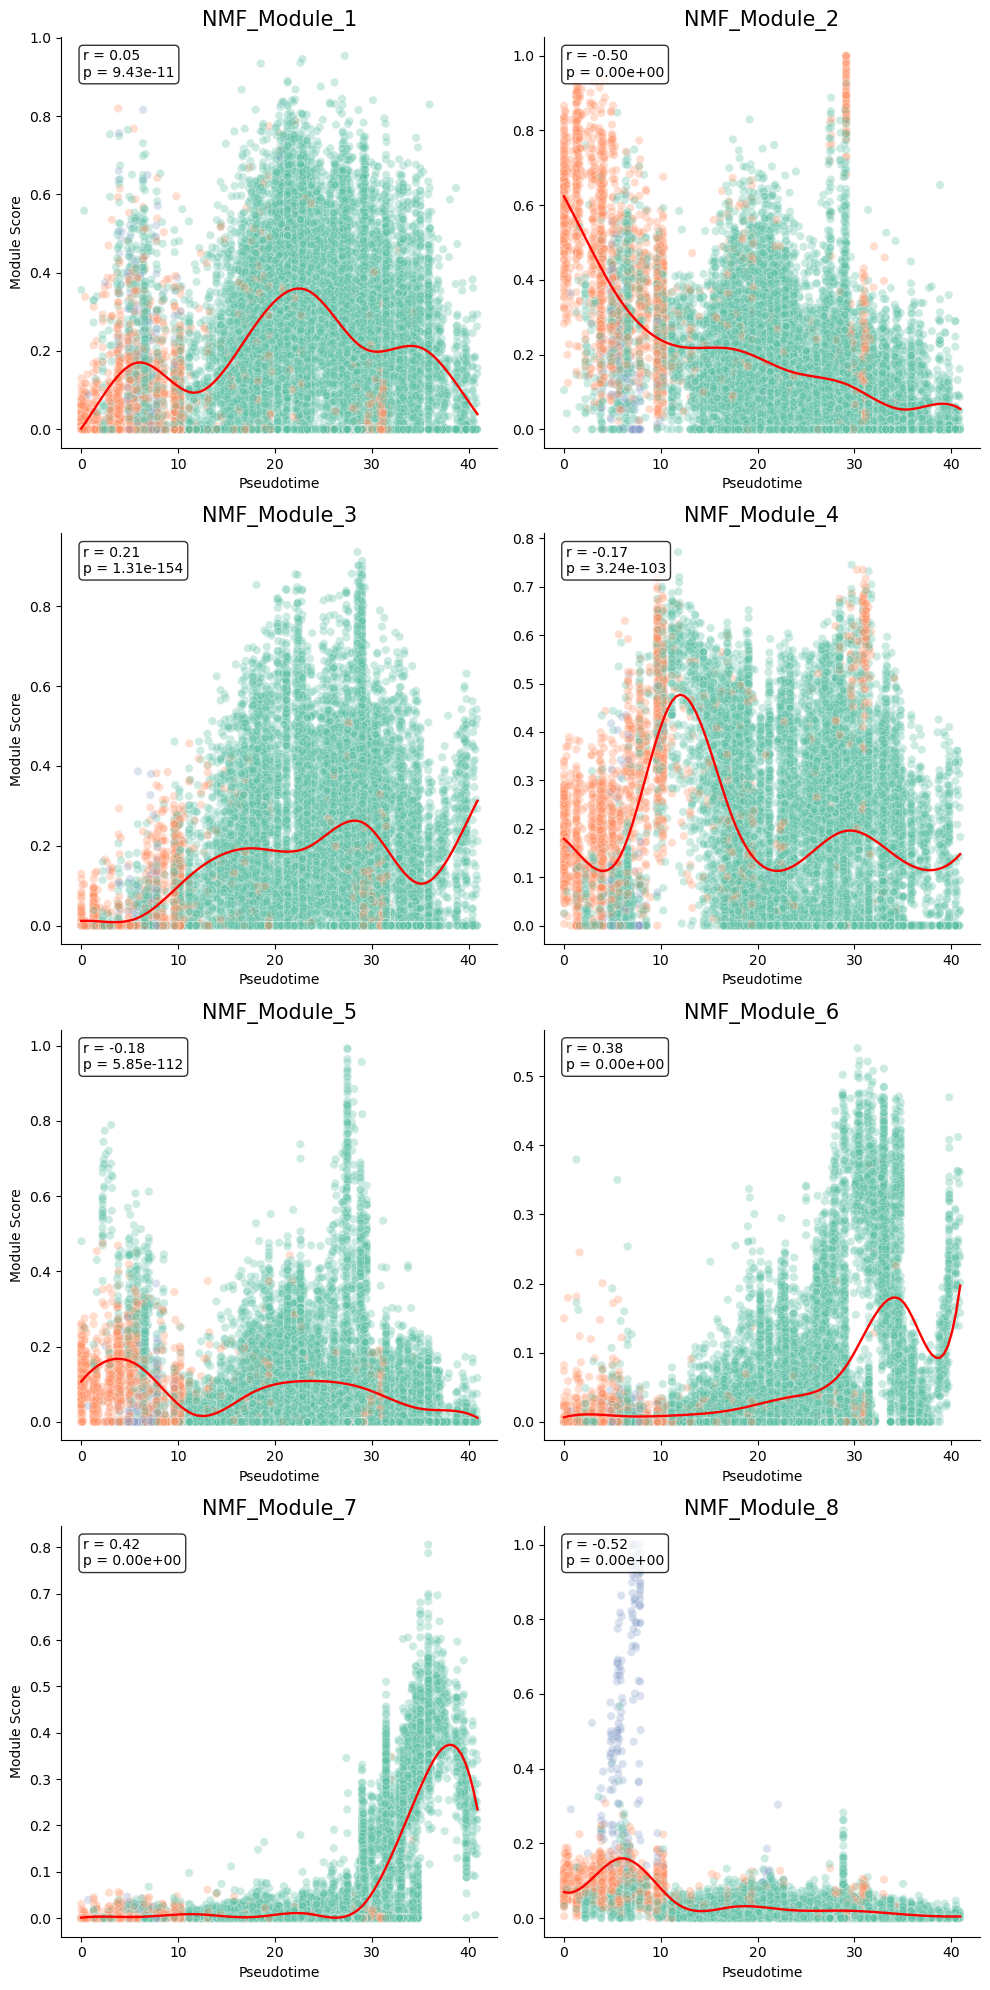

In [141]:
fig, axes = plt.subplots(4,2, figsize=(10, 20))
axes = axes.flatten()

for i, (module, ax) in enumerate(zip(modules, axes)):
    x = adata.obs.pseudotime.values
    y = adata.obs[module].values
    hue = adata.obs.cell_type.values
        
    x_pred = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
    y_pred = results[module]['gam'].predict(x_pred)

    with mplscience.style_context(reset_current=True):
        sns.scatterplot(x=x, y=y, hue=hue, alpha=0.3, palette=['#5CC0A5', '#FF8F62', '#89A0CB'], ax=ax, legend = False)
        ax.plot(x_pred, y_pred, color='red')
        ax.set_title(f"{module}")
        ax.set_xlabel("Pseudotime")
        ax.set_ylabel("Module Score" if i % 2 == 0 else "")
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
    corr = results[module]['correlation']
    p_val = adjusted_p_values[i]
    ax.text(0.05, 0.97, f"r = {corr:.2f}\np = {p_val:.2e}", 
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
plt.tight_layout()
plt.savefig(os.path.join(plot_path, 'X_module_pseudotime.pdf'), dpi = 300, format = 'pdf', bbox_inches = 'tight')
plt.show()
        